# Algorithmes quantiques simples

## Deutsch-Jozsa algorithm

Deutsch's problem: Alice wants to determine whether Bob's function $f(x)$ ($0 \leq x \leq 2^n -1$) is constant (always 0 or always 1) or balanced (0 on half of the entries, 1 on the other half).

$f$ is of course unknown to Alice.

### Deutsch-Jozsa oracle

We first construct the quantum routine $U$ corresponding to the oracle:

$$ U_{f}|x\rangle|y\rangle\mapsto|x\rangle|y\oplus f(x)\rangle $$

In [1]:
from qat.lang.AQASM import H, X, CNOT, Program, QRoutine

def dj_oracle(func):
    """ construct quantum routine corresponding
    to Deutsch-Josza's oracle for a 2-qubit function f.
    
    Args:
        func (int):
            if func=0, f is a constant = 0;
            if func=1, f is a constant = 1;
            if func=2, f is balanced: f(00) = f(11) = 0, and f(01) = f(10) = 1
            
    Returns:
        QRoutine: the quantum routine of DJ algo
        
    Note:
        It would be even better to have implem where f is specified by its action on input states,
        and oracle circuit is synthesized accordingly
    """
    routine = QRoutine(3) 
    if func == 0:  
        return routine
    if func == 1:
        routine.apply(X, 2) # if f : constant = 1
        return routine
    # else
    routine.apply(CNOT, 0, 2)
    routine.apply(CNOT, 1, 2)
    return routine

### Deutsch-Jozsa program

We now write the full program

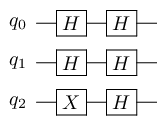

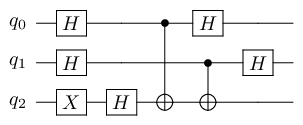

In [2]:
def make_dj_circuit(func):
    prog = Program()
    reg = prog.qalloc(3) # 2 qubits to encode x

    X(reg[2])

    for qb in range(3):
        H(reg[qb])

    prog.apply(dj_oracle(func), reg)

    for qb in range(2):
        H(reg[qb])

    circ = prog.to_circ()
    return circ

circ = make_dj_circuit(0)
%qatdisplay circ

circ = make_dj_circuit(2)
%qatdisplay circ

We run it for different functions $f$:

In [3]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()
for func in [0, 1, 2]:
    print("==== func = %s ===="%func)
    circ = make_dj_circuit(func)
    job = circ.to_job(nbshots=1, qubits=[0, 1])  # we measure only the qubits of the query register
    res = qpu.submit(job)
    for sample in res:
        print(sample.state, sample.probability)

==== func = 0 ====
|00> 1.0
==== func = 1 ====
|00> 1.0
==== func = 2 ====
|11> 1.0


We can check that for constant functions, we get state $|00\rangle$.

## Bernstein-Vazirani algorithm

Goal: find bitstring $s$ that appears in definition of function $f(x) = x \cdot s$.

Reminder of the trick: the oracle to realize $\tilde{U}_f$ needs to implement $\tilde{U}_f: |x\rangle \rightarrow (-)^{f(x)} |x\rangle$. To do this, we can use the oracle used for Deutsch-Josza, $ U_f : |x\rangle |y\rangle \rightarrow |x \rangle |y \oplus f(x)\rangle$, with $|y\rangle = (|0\rangle - |1\rangle)/\sqrt{2}$.


In [46]:
def dot_product(bitstring):
    """Construct quantum routine that does |a>|b> -> |a>|b + a.s mod. 2>
    where a.s is the dot product between a and a bitstring s. The second register 
    is a one-qbit register.
    
    Args:
        bitstring (str): a bitstring
    Returns:
        QRoutine: the corresponding quantum routine
    """
    qrout = QRoutine()
    a_reg = qrout.new_wires(len(bitstring))
    b_reg = qrout.new_wires(1)
    for pos, bit in enumerate(bitstring):
        if bit == "1":
            qrout.apply(CNOT, a_reg[pos], b_reg)
    return qrout

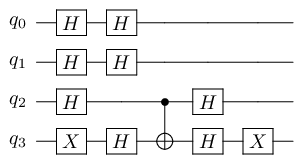

|4> 0.9999999999999987


In [52]:
import qat.lang.AQASM.classarith
from qat.lang.AQASM.arithmetic import mult_const_mod
from qat.lang.AQASM import QInt

hidden_string = "001" # 4
n_data_bits = len(hidden_string)

prog = Program()
reg = prog.qalloc(n_data_bits, class_type=QInt, reverse_bit_order=True)
ancilla = prog.qalloc(1, class_type=QInt, reverse_bit_order=True)

for qb in range(n_data_bits):
    H(reg[qb])
prog.apply(X, ancilla[0])
prog.apply(H, ancilla[0]) # to obtain |0> - |1> on ancilla qubit

prog.apply(dot_product(hidden_string), reg, ancilla)

for qb in range(n_data_bits): # on data qubits only
    H(reg[qb])
    
prog.apply(H, ancilla[0])
prog.apply(X, ancilla[0])
    
circ = prog.to_circ(link=[qat.lang.AQASM.qftarith])
%qatdisplay circ
qpu = get_default_qpu()
job = circ.to_job(nbshots=0, qubits=reg)
res = qpu.submit(job)

list_states = []
for sample in res:
    list_states.append((sample.probability, sample.state))
for prob, state in reversed(sorted(list_states,  key=lambda x: x[0])):
    print(state, prob)

## With a Noisy QPU

In [ ]:
from depolarizing_plugin import DepolarizingPlugin

depol_plugin = DepolarizingPlugin(prob_1qb=0.005, prob_2qb=0.05)

qpu = get_default_qpu()

noisy_qpu = depol_plugin | qpu

res = noisy_qpu.submit(job)

list_states = []
for sample in res:
    list_states.append((sample.probability, sample.state))
for prob, state in reversed(sorted(list_states,  key=lambda x: x[0])):
    print(state, prob)

15
